# Wstęp do multimediów - Laboratorium 7

Analiza obrazu - detekcja twarzy

Bartłomiej Krawczyk
310774

Grupa 103

In [1]:
import cv2
import dlib

from IPython.display import Image, display

from typing import NamedTuple

import time

In [2]:
OUTPUT_IMAGE_FILE_PATH = './output/'

def show_image(image, name='output.png'):
    cv2.imwrite(OUTPUT_IMAGE_FILE_PATH + name, image)
    display(Image(filename=OUTPUT_IMAGE_FILE_PATH + name))

Po uruchomieniu notatnika popierany jest przykładowy obraz testowy z bazy Wider oraz zbiory danych (modele) dla kaskady **Haara** i **MMOD**. Następnie w obrazie testowym przy użyciu trzech detektorów wykrywane są twarze.

## Inicjalizacja - pobranie obrazu testowego i modeli dla detektorów twarzy

In [3]:
class File(NamedTuple):
    id: str
    file: str
    hash: str

IMAGE = File('1gn7itC80mnmp9TSK8PHMEZSKMOuBVUEQ','./output/image.jpg', '0f8c44e5e564e71d95bb3f5247ebae20')
HAAR_DETECTOR = File('1UoFK0Jl7tY1z0ykdlvaxkFmyUR8lmLul', './output/haar_detector.xml', 'a03f92a797e309e76e6a034ab9e02616')
CNN_DETECTOR = File('1tb4P8NEcwTnja182AFDDnXM5ijTNQwj_', './output/mmod_detector.dat', '2ac022385c5a56f8313ca9827ff76c3d')

files = [IMAGE, HAAR_DETECTOR, CNN_DETECTOR]

import gdown

for id, file, hash in files:
    gdown.download(f'https://drive.google.com/uc?id={id}', file)

Downloading...
From: https://drive.google.com/uc?id=1gn7itC80mnmp9TSK8PHMEZSKMOuBVUEQ
To: /home/bartlomiejkrawczyk/WMM/lab_7/output/image.jpg
100%|██████████| 147k/147k [00:00<00:00, 2.76MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UoFK0Jl7tY1z0ykdlvaxkFmyUR8lmLul
To: /home/bartlomiejkrawczyk/WMM/lab_7/output/haar_detector.xml
100%|██████████| 930k/930k [00:00<00:00, 7.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tb4P8NEcwTnja182AFDDnXM5ijTNQwj_
To: /home/bartlomiejkrawczyk/WMM/lab_7/output/mmod_detector.dat
100%|██████████| 730k/730k [00:00<00:00, 5.82MB/s]


### Weryfikacja pobranych danych

In [4]:
for id, file, hash in files:
    md5 = gdown.md5sum(file)
    assert(hash == md5)
    print(file, md5, sep='\t')

./output/image.jpg	0f8c44e5e564e71d95bb3f5247ebae20
./output/haar_detector.xml	a03f92a797e309e76e6a034ab9e02616
./output/mmod_detector.dat	2ac022385c5a56f8313ca9827ff76c3d


## Obraz testowy

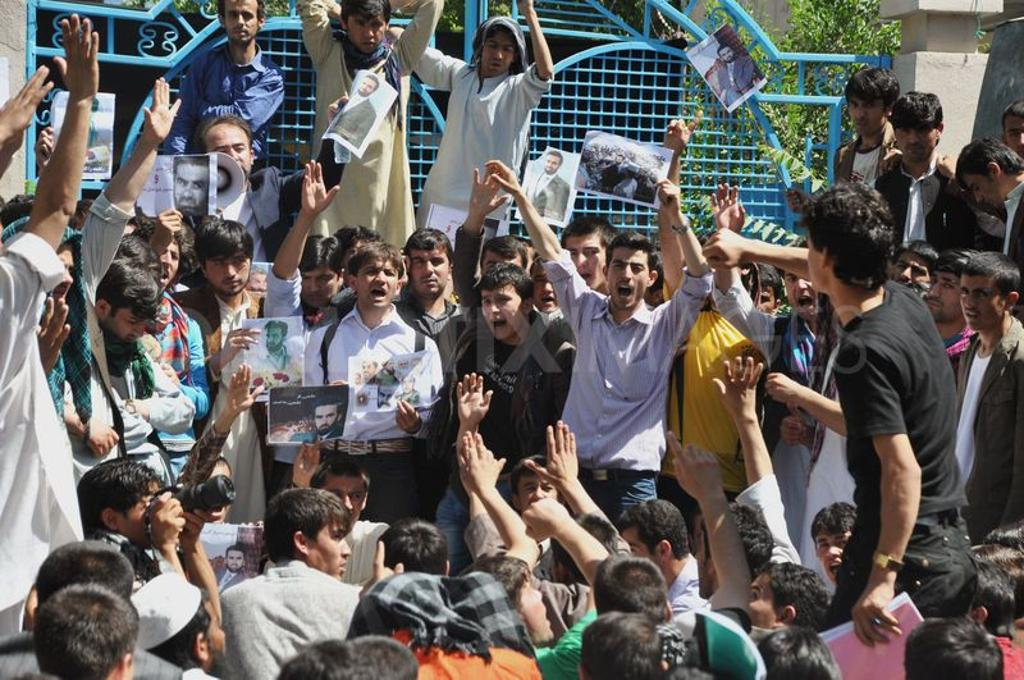

In [5]:
img = cv2.imread(IMAGE.file)
IMAGE_NAME = '2_Demonstration_Demonstration_Or_Protest_2_1.jpg'

show_image(img)

In [6]:
def summary(detection_result):
    print(f'Znalezionych (potencjalnych) twarzy: {len(detection_result[0])}')
    print(f'Czas detekcji: {detection_result[2]}')
    show_image(detection_result[1])

## Kaskada Haara

In [7]:
haar_detector = cv2.CascadeClassifier(HAAR_DETECTOR.file)

In [8]:
def haar_detect(image, _=None):
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	start = time.perf_counter()
	rects = haar_detector.detectMultiScale(gray, scaleFactor=1.05,
										minNeighbors=5, minSize=(30, 30),
										flags=cv2.CASCADE_SCALE_IMAGE)
	end = time.perf_counter()

	img_haar = image.copy()
	for (x, y, w, h) in rects:
		cv2.rectangle(img_haar, (x, y), (x + w, y + h), (0, 255, 0), 2)

	return rects, img_haar, end - start

Znalezionych (potencjalnych) twarzy: 13
Czas detekcji: 0.400695899999846


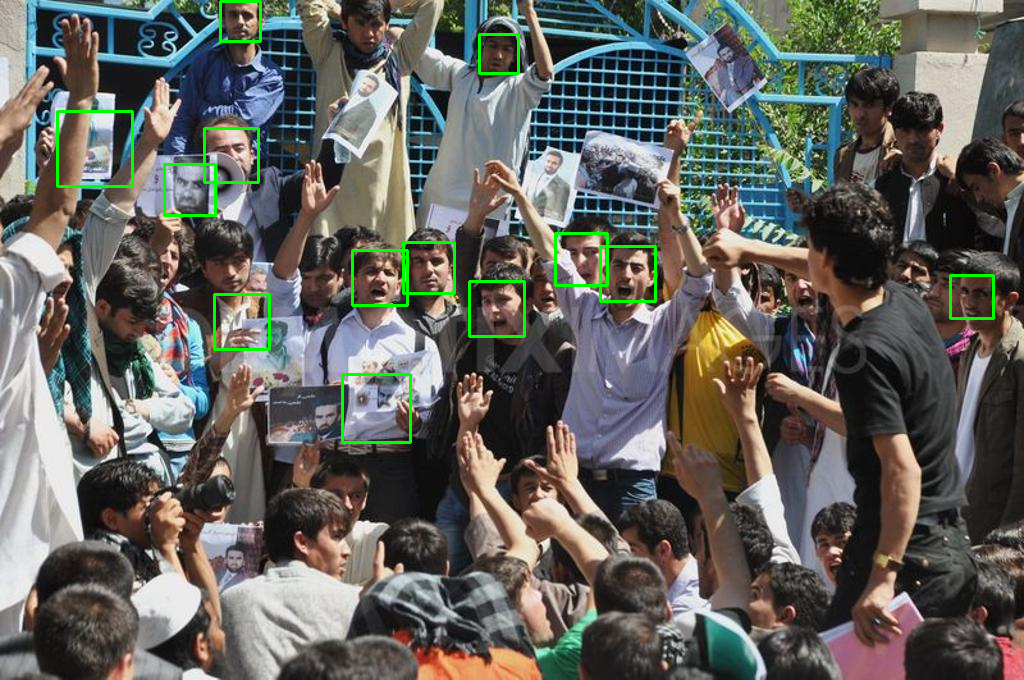

In [9]:
summary(haar_detect(img))

## Histogram zorientowanych gradientów (HOG) z maszyną wektorów nośnych (SVM)

In [10]:
hog_svm_detector = dlib.get_frontal_face_detector()

In [11]:
def convert_and_trim_bb(image, rect):
	# extract the starting and ending (x, y)-coordinates of the
	# bounding box
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()
	# ensure the bounding box coordinates fall within the spatial
	# dimensions of the image
	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])
	# compute the width and height of the bounding box
	w = endX - startX
	h = endY - startY
	# return our bounding box coordinates
	return (startX, startY, w, h)
    
def hog_svm_detect(image, _=None):
	rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

	start = time.perf_counter()
	hog_svm_rects = hog_svm_detector(rgb, 1)
	end = time.perf_counter()
	
	hog_svm_boxes = [convert_and_trim_bb(image, r) for r in hog_svm_rects]
	
	img_hog_svm = image.copy()
	for (x, y, w, h) in hog_svm_boxes:
		cv2.rectangle(img_hog_svm, (x, y), (x + w, y + h), (0, 255, 0), 2)

	return hog_svm_boxes, img_hog_svm, end - start

Znalezionych (potencjalnych) twarzy: 8
Czas detekcji: 0.5722323000009055


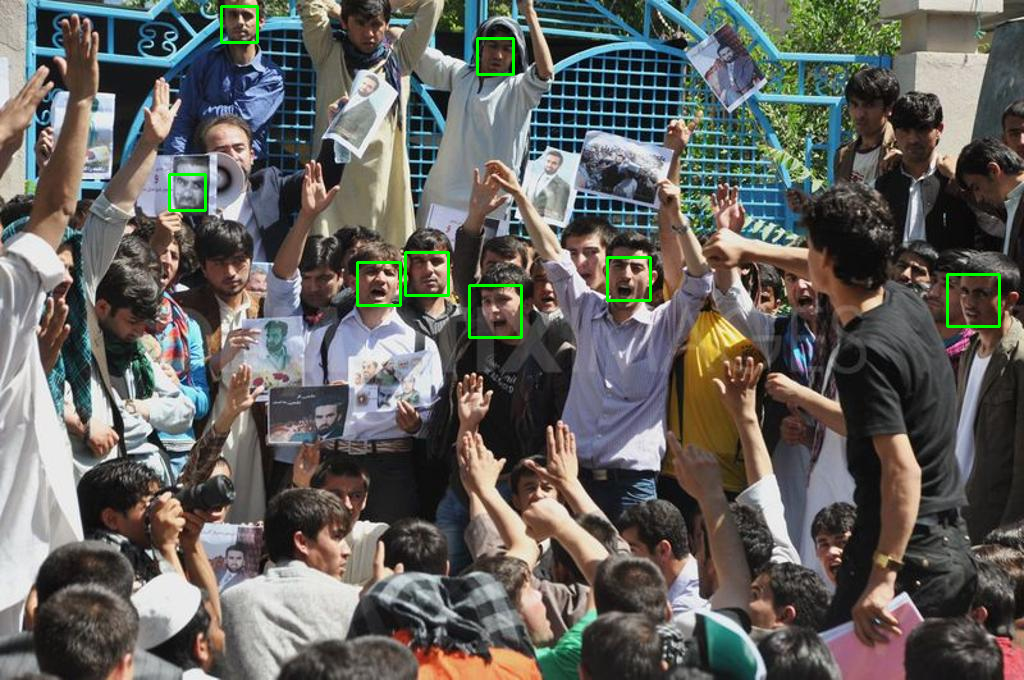

In [12]:
summary(hog_svm_detect(img))

## Splotowa sieć neuronowa (CNN)

In [13]:
cnn_detector = dlib.cnn_face_detection_model_v1(CNN_DETECTOR.file)

In [14]:
def cnn_detect(image, _=None):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    start = time.perf_counter()
    cnn_rects = cnn_detector(rgb, 1)
    end = time.perf_counter()

    cnn_boxes = [convert_and_trim_bb(image, r.rect) for r in cnn_rects]

    img_cnn = image.copy()
    for (x, y, w, h) in cnn_boxes:
        cv2.rectangle(img_cnn, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return cnn_boxes, img_cnn, end - start

Znalezionych (potencjalnych) twarzy: 20
Czas detekcji: 21.505659300000843


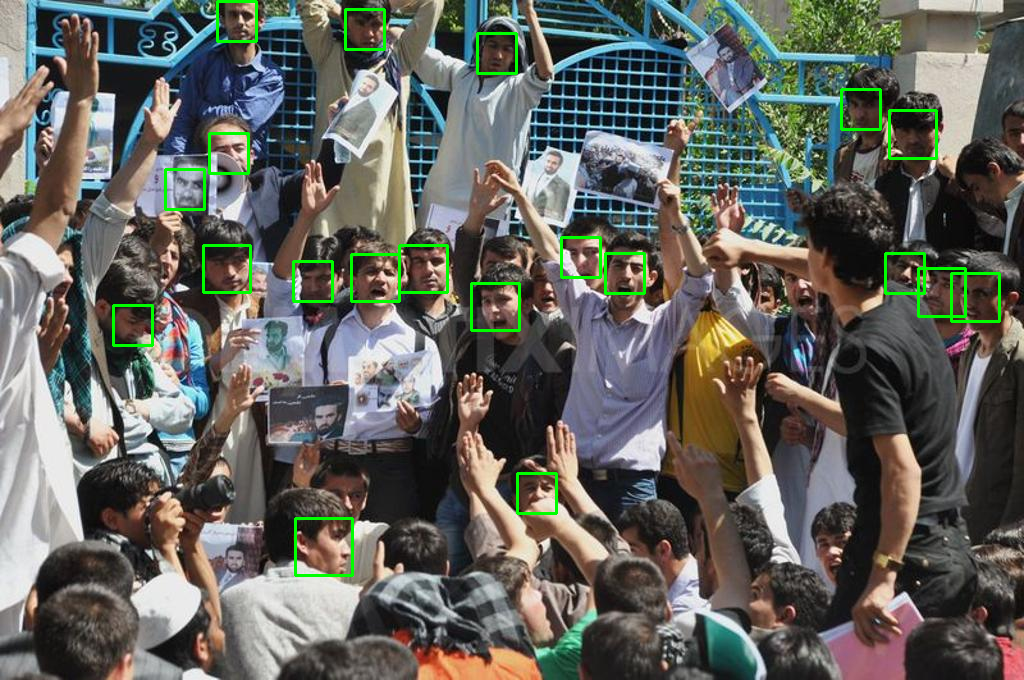

In [15]:
summary(cnn_detect(img))

## Ground Truth

In [16]:
# The format of txt ground truth.
# File name
# Number of bounding box
# x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose

TRUTH = {}

with open('./images/ground_truth_bbx.txt', 'r') as file:
    
    while True:
        file_name = file.readline()
        if not file_name:
            break
        file_name = file_name.split('/')[1]
        file_name = file_name.rstrip()
        rectangles = int(file.readline())
        rect = []
        for _ in range(rectangles):
            rectangle = [int(val) for val in file.readline().split(' ')[:4]]
            rect.append(rectangle)
        
        TRUTH[file_name] = rect

In [17]:
def ground_truth_detect(image, file_name):
    boxes = TRUTH[file_name]

    img = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return boxes, img, 0.0

Znalezionych (potencjalnych) twarzy: 24
Czas detekcji: 0.0


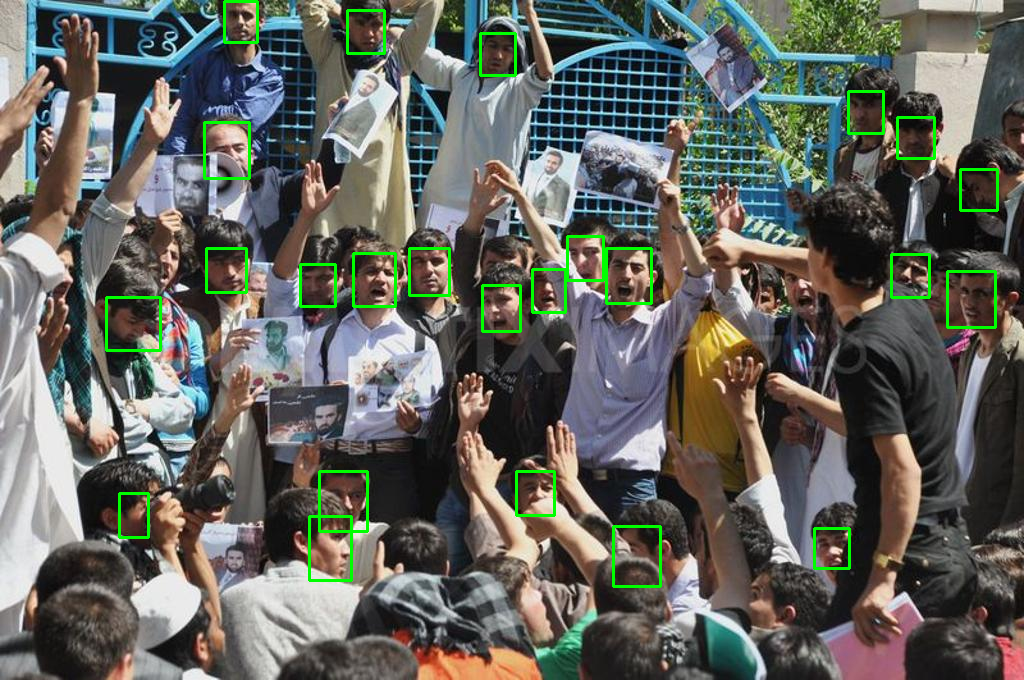

In [18]:
summary(ground_truth_detect(img, IMAGE_NAME))

In [19]:
detection_functions = [ground_truth_detect, haar_detect, hog_svm_detect, cnn_detect]

image_num = 0

with open('./output/result.md', 'w') as file:
    file.write('Dana |Ground Truth | HAAR |  HOG z SVM | CNN\n-|-|-|-|-\n')

with open('./output/times.md', 'w') as file:
    file.write('Zdjęcie | HAAR |  HOG z SVM | CNN\n-|-|-|-\n')

def add_image_row(file, images, file_name):
    row = f'{file_name} |'
    
    for i, img in enumerate(images):
        filename = f'./output/{image_num}_{i}.png'
        cv2.imwrite(filename, img)
        row += f'![]({filename})|'
    
    row = row[:-1] + '\n'
    file.write(row)

def add_detections_number_row(file, result_boxes):
    row = 'Liczba wszystkich detekcji |'

    for b in result_boxes:
        row += f'{len(b)}|'

    row = row[:-1] + '\n'
    file.write(row)

all = [0] * 4
correct = [0] * 4
incorrect = [0] * 4
not_found = [0] * 4

def save_statistics():
    global all
    global correct
    global incorrect
    global not_found
    
    with open('./output/stats.md', 'w') as stats:
        stats.write('Statystyka | Ground Truth | HAAR |  HOG z SVM | CNN\n-|-|-|-|-\n')
        all_row = 'Liczba wszystkich detekcji |'
        for val in all:
            all_row += f'{val} |'
        stats.write(all_row[:-1] + '\n')
        correct_row = 'Liczba poprawnych detekcji |'
        for val in correct:
            correct_row += f'{val} |'
        stats.write(correct_row[:-1] + '\n')
        incorrect_row = 'Liczba niepoprawnych detekcji |'
        for val in incorrect:
            incorrect_row += f'{val} |'
        stats.write(incorrect_row[:-1] + '\n')
        not_found_row = 'Liczba niewykrytych twarzy|'
        for val in not_found:
            not_found_row += f'{val} |'
        stats.write(not_found_row[:-1] + '\n')

def add_statistics_rows(file, result_boxes):
    global all
    global correct
    global incorrect
    global not_found

    for i, boxes in enumerate(result_boxes):
        all[i] += len(boxes)
    
    correct[0] += len(result_boxes[0])
    
    correct_row = f'Liczba poprawnych detekcji |{len(result_boxes[0])}|'
    incorrect_row = f'Liczba niepoprawnych detekcji |0|'
    not_found_row = f'Liczba niewykrytych twarzy |0|'

    for i, rectangles in enumerate(result_boxes[1:], start=1):
        num = 0
        for rect in rectangles:
            # Check if middle point of the rectangle is inside a ground truth rectangle 
            point = (rect[0] + rect[2] / 2, rect[1] + rect[3] / 2)
            for tr in result_boxes[0]:
                if tr[0] < point[0] and  tr[0] + tr[2] > point[0] \
                    and tr[1] < point[1] and  tr[1] + tr[3] > point[1]:
                    num += 1
                    break
        correct_row += f'{num}|'
        incorrect_row += f'{len(rectangles) - num}|'
        not_found_row += f'{len(result_boxes[0]) - num}|'

        correct[i] += num
        incorrect[i] += len(rectangles) - num
        not_found[i] += len(result_boxes[0]) - num

    file.write(correct_row[:-1] + '\n')
    file.write(incorrect_row[:-1] + '\n')
    file.write(not_found_row[:-1] + '\n')

    save_statistics()
        

def add_time_row(file, times, file_name):
    row = 'Czas detekcji |'

    for t in times:
        row += f'{t}|'
        
    row = row[:-1] + '\n'
    file.write(row)

    with open('./output/times.md', 'a') as times:
        times.write(file_name + '|' + row[19:])

def save_detected(image, file_name):
    with open('./output/result.md', 'a') as file:
        global image_num
        
        results = []
        for func in detection_functions:
            results.append(func(image, file_name))

        add_image_row(file, [img[1] for img in results], file_name)

        add_detections_number_row(file, [box[0] for box in results])

        add_statistics_rows(file, [box[0] for box in results])

        add_time_row(file, [time[2] for time in results], file_name)

        image_num += 1

In [20]:
save_detected(img, IMAGE_NAME)

| Dana                                                  | Ground Truth          | HAAR                  | HOG z SVM             | CNN                   |
|-------------------------------------------------------|-----------------------|-----------------------|-----------------------|-----------------------|
| 2_Demonstration_Demonstration_Or_Protest_2_1.jpg      | ![](./output/0_0.png) | ![](./output/0_1.png) | ![](./output/0_2.png) | ![](./output/0_3.png) |
| Liczba wszystkich detekcji                            | 24                    | 13                    | 8                     | 20                    |
| Liczba poprawnych detekcji                            | 24                    | 9                     | 7                     | 18                    |
| Liczba niepoprawnych detekcji                         | 0                     | 4                     | 1                     | 2                     |
| Liczba niewykrytych twarzy                            | 0                     | 15                    | 17                    | 6                     |
| Czas detekcji                                         | 0.0                   | 0.5737859000000753    | 0.5594495000004827    | 22.736124799997924    |

In [21]:
from pathlib import Path
from random import shuffle, seed

directory = Path('./images/')

images = list(directory.glob('*.jpg'))

seed(1)
shuffle(images)
images = images[:7]


for image in images:
    save_detected(cv2.imread(str(image.absolute())), image.name)

| Dana                                                  | Ground Truth          | HAAR                  | HOG z SVM             | CNN                   |
|-------------------------------------------------------|-----------------------|-----------------------|-----------------------|-----------------------|
| 29_Students_Schoolkids_Students_Schoolkids_29_251.jpg | ![](./output/1_0.png) | ![](./output/1_1.png) | ![](./output/1_2.png) | ![](./output/1_3.png) |
| Liczba wszystkich detekcji                            | 21                    | 16                    | 17                    | 19                    |
| Liczba poprawnych detekcji                            | 21                    | 15                    | 17                    | 19                    |
| Liczba niepoprawnych detekcji                         | 0                     | 1                     | 0                     | 0                     |
| Liczba niewykrytych twarzy                            | 0                     | 6                     | 4                     | 2                     |
| Czas detekcji                                         | 0.0                   | 0.4900798999988183    | 0.5829212999997253    | 24.03433380000206     |
| 2_Demonstration_Demonstration_Or_Protest_2_15.jpg     | ![](./output/2_0.png) | ![](./output/2_1.png) | ![](./output/2_2.png) | ![](./output/2_3.png) |
| Liczba wszystkich detekcji                            | 11                    | 10                    | 5                     | 7                     |
| Liczba poprawnych detekcji                            | 11                    | 7                     | 5                     | 7                     |
| Liczba niepoprawnych detekcji                         | 0                     | 3                     | 0                     | 0                     |
| Liczba niewykrytych twarzy                            | 0                     | 4                     | 6                     | 4                     |
| Czas detekcji                                         | 0.0                   | 0.30790109999725246   | 0.5209047999996983    | 22.780104700002994    |
| 46_Jockey_Jockey_46_352.jpg                           | ![](./output/3_0.png) | ![](./output/3_1.png) | ![](./output/3_2.png) | ![](./output/3_3.png) |
| Liczba wszystkich detekcji                            | 20                    | 27                    | 20                    | 20                    |
| Liczba poprawnych detekcji                            | 20                    | 20                    | 20                    | 20                    |
| Liczba niepoprawnych detekcji                         | 0                     | 7                     | 0                     | 0                     |
| Liczba niewykrytych twarzy                            | 0                     | 0                     | 0                     | 0                     |
| Czas detekcji                                         | 0.0                   | 0.3437240999992355    | 0.5058594000001904    | 21.596691399998235    |
| 50_Celebration_Or_Party_birthdayparty_50_18.jpg       | ![](./output/4_0.png) | ![](./output/4_1.png) | ![](./output/4_2.png) | ![](./output/4_3.png) |
| Liczba wszystkich detekcji                            | 15                    | 5                     | 0                     | 0                     |
| Liczba poprawnych detekcji                            | 15                    | 1                     | 0                     | 0                     |
| Liczba niepoprawnych detekcji                         | 0                     | 4                     | 0                     | 0                     |
| Liczba niewykrytych twarzy                            | 0                     | 14                    | 15                    | 15                    |
| Czas detekcji                                         | 0.0                   | 0.2698357999979635    | 0.43181239999830723   | 24.52027520000047     |
| 11_Meeting_Meeting_11_Meeting_Meeting_11_71.jpg       | ![](./output/5_0.png) | ![](./output/5_1.png) | ![](./output/5_2.png) | ![](./output/5_3.png) |
| Liczba wszystkich detekcji                            | 11                    | 8                     | 5                     | 8                     |
| Liczba poprawnych detekcji                            | 11                    | 6                     | 5                     | 8                     |
| Liczba niepoprawnych detekcji                         | 0                     | 2                     | 0                     | 0                     |
| Liczba niewykrytych twarzy                            | 0                     | 5                     | 6                     | 3                     |
| Czas detekcji                                         | 0.0                   | 0.3083206999981485    | 0.48703759999989416   | 26.54973120000068     |
| 13_Interview_Interview_2_People_Visible_13_252.jpg    | ![](./output/6_0.png) | ![](./output/6_1.png) | ![](./output/6_2.png) | ![](./output/6_3.png) |
| Liczba wszystkich detekcji                            | 13                    | 13                    | 7                     | 8                     |
| Liczba poprawnych detekcji                            | 13                    | 9                     | 7                     | 8                     |
| Liczba niepoprawnych detekcji                         | 0                     | 4                     | 0                     | 0                     |
| Liczba niewykrytych twarzy                            | 0                     | 4                     | 6                     | 5                     |
| Czas detekcji                                         | 0.0                   | 0.3879065000000992    | 0.4247185999993235    | 23.55352420000054     |
| 54_Rescue_rescuepeople_54_32.jpg                      | ![](./output/7_0.png) | ![](./output/7_1.png) | ![](./output/7_2.png) | ![](./output/7_3.png) |
| Liczba wszystkich detekcji                            | 6                     | 2                     | 2                     | 2                     |
| Liczba poprawnych detekcji                            | 6                     | 2                     | 2                     | 2                     |
| Liczba niepoprawnych detekcji                         | 0                     | 0                     | 0                     | 0                     |
| Liczba niewykrytych twarzy                            | 0                     | 4                     | 4                     | 4                     |
| Czas detekcji                                         | 0.0                   | 0.3636876000018674    | 0.5462456999994174    | 22.72536200000104     |


# Wyniki

## Skuteczność algorytmów

| Statystyka                    | Ground Truth | HAAR | HOG z SVM | CNN |
|-------------------------------|--------------|------|-----------|-----|
| Liczba wszystkich detekcji    | 121          | 94   | 64        | 84  |
| Liczba poprawnych detekcji    | 121          | 69   | 63        | 82  |
| Liczba niepoprawnych detekcji | 0            | 25   | 1         | 2   |
| Liczba niewykrytych twarzy    | 0            | 52   | 58        | 39  |


## Czasy wykonania

| Zdjęcie                                               | HAAR                | HOG z SVM           | CNN                |
|-------------------------------------------------------|---------------------|---------------------|--------------------|
| 2_Demonstration_Demonstration_Or_Protest_2_1.jpg      | 0.5737859000000753  | 0.5594495000004827  | 22.736124799997924 |
| 29_Students_Schoolkids_Students_Schoolkids_29_251.jpg | 0.4900798999988183  | 0.5829212999997253  | 24.03433380000206  |
| 2_Demonstration_Demonstration_Or_Protest_2_15.jpg     | 0.30790109999725246 | 0.5209047999996983  | 22.780104700002994 |
| 46_Jockey_Jockey_46_352.jpg                           | 0.3437240999992355  | 0.5058594000001904  | 21.596691399998235 |
| 50_Celebration_Or_Party_birthdayparty_50_18.jpg       | 0.2698357999979635  | 0.43181239999830723 | 24.52027520000047  |
| 11_Meeting_Meeting_11_Meeting_Meeting_11_71.jpg       | 0.3083206999981485  | 0.48703759999989416 | 26.54973120000068  |
| 13_Interview_Interview_2_People_Visible_13_252.jpg    | 0.3879065000000992  | 0.4247185999993235  | 23.55352420000054  |
| 54_Rescue_rescuepeople_54_32.jpg                      | 0.3636876000018674  | 0.5462456999994174  | 22.72536200000104  |

# Wnioski



### Kaskada Haara:

Zalety:
- najkrótszy czas działania ze wszystkich testowanych algorytmów
- niewielkie nakłady obliczeniowe
- możliwa detekcja twarzy w czasie rzeczywistym

Wady:
- duża liczba niepoprawnych detekcji

### Histogram Zorientowanych Gradientów z Maszyną Wektorów Nośnych jako klasyfikator:

Zalety:
- krótki czas działania algorytmu
- wszystkie oznaczone twarze są poprawne
    - ta jedna niepoprawna detekcja ze statystyk to jedynie nie oznaczone twarz w pliku `ground_truth_bbx.txt`, a nie pomyłka algorytmu

Wady:
- wykrył najmniejszą ilość twarzy (około 52% twarzy)

### Splotowa sieć neuronowa (Convlutional Neural  Networks)

Zalety:
- poradziła sobie najlepiej ze wszystkich dostępnych algorytmów
- wykryła poprawnie największą ilość twarzy
- wszystkie oznaczone twarze są poprawne
    - te dwie niepoprawne detekcje ze statystyk to jedynie nie oznaczone twarze w pliku `ground_truth_bbx.txt`, a nie pomyłka algorytmu

Wady:
- znacznie dłuższy czas działania algorytmu
- podejrzewam, że algorytm ze wspomaganiem GPU osiągnął by o wiele lepsze wyniki
- jednakże, nie zmienia to faktu, że do detekcji należy wykorzystać o wiele więcej zasobów niż w przypadku poprzednich algorytmów